In [1]:
import sys, os

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP
from cnep import CNEP

import numpy as np
import torch
from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import matplotlib.pyplot as plt

In [2]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_path = 'ablation/unimodal/orig_0_1_2_cnmp/1717370718/'

data_path = root_path + test_path + 'y.pt'

Y = torch.load(data_path, map_location='cpu').to('cpu').numpy().squeeze(-1)
x = np.linspace(0, 1, Y.shape[1])
print(f'x: {x.shape}, Y: {Y.shape}')

num_modes = 1
num_demos = Y.shape[0]
num_indiv = Y.shape[0]//num_modes
t_steps = Y.shape[1]

Y_means = np.zeros((num_modes,Y.shape[1]))
for i in range(num_modes):
    Y_means[i] = np.mean(Y[i*num_indiv:(i+1)*num_indiv], axis=0)

x: (100,), Y: (24, 100)


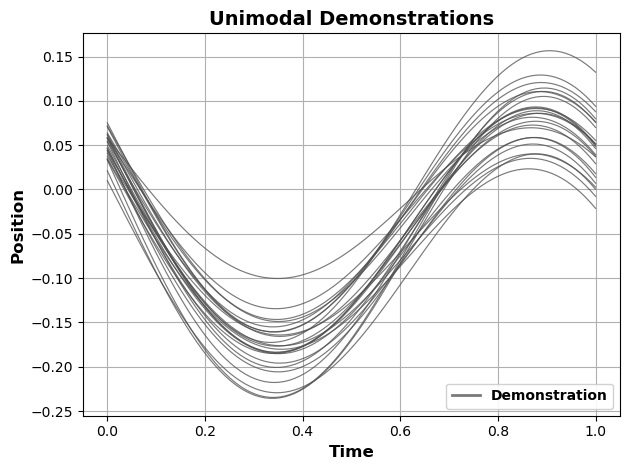

In [3]:
# plot Y and Y_means
# plt.plot(x, Y.T, color='gray', alpha=0.15)
# plt.plot(x, Y_means.T, label='Mean Y', alpha=0.85, linewidth=2)
# plt.legend()
# plt.grid()
# plt.show()

from matplotlib.lines import Line2D

dark_gray = '#4d4d4d'
for i in range(Y.shape[0]):
    plt.plot(x, Y[i], color=dark_gray, alpha=0.75, linewidth=0.85)

plt.title('Unimodal Demonstrations', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.ylabel('Position', fontsize=12, fontweight='bold')

handles = [Line2D([0], [0], color=dark_gray, lw=2, alpha=0.75, label='Demonstration')]

plt.legend(handles=handles, fontsize=12, loc='lower right', frameon=True, framealpha=0.9, prop=dict(weight='bold'))
plt.grid()
plt.tight_layout()
plt.savefig(f'unimodal_demonstration.svg', format='svg', dpi=300)
plt.show()

In [4]:
def find_closest_traj_ind(traj, cut=0):
    # find the closest trajectory in the dataset
    min_dist = np.inf
    min_ind = -1
    traj = traj[:-cut] if cut != 0 else traj
    traj_length = traj.shape[0]
    for i, y in enumerate(Y):
        if cut != 0:
            dist = compute_euclidean_dist(y[-traj_length-cut:-cut], traj)  # euclidean distance between two trajectories
        else:
            dist = compute_euclidean_dist(y, traj)
        if dist < min_dist:
            min_dist = dist
            min_ind = i
    return min_ind, min_dist


def compute_euclidean_dist(traj0, traj1):
    traj_length = traj0.shape[np.argmax(traj0.shape)]
    assert traj_length > 10, f"Trajectory length is too short: {traj_length}"
    
    traj0 = traj0.reshape(traj_length)
    traj1 = traj1.reshape(traj_length)

    dist = np.sum(np.sqrt((traj0 - traj1) ** 2))
    coeff = t_steps/traj_length
    return dist * coeff

In [5]:
model_folder = 'saved_models/'
models_path = f'{root_path}{test_path}{model_folder}'

m_path, m0_path, m1_path, m2_path, m3_path = f'{models_path}org.pt', f'{models_path}abl0.pt', f'{models_path}abl1.pt', f'{models_path}abl2.pt', f'{models_path}cnmp.pt'

batch_size = 1
dx, dy = 1, 1
n_max, m_max = 6, 6
t_steps = 100
device = 'cpu'

cnmp = CNMP(dx, dy, n_max, m_max, [128,128], decoder_hidden_dims=[128,128], batch_size=batch_size, device=device)
cnep = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep0 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep1 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep2 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)

cnep.load_state_dict(torch.load(m_path, map_location='cpu'))
cnep0.load_state_dict(torch.load(m0_path, map_location='cpu'))
cnep1.load_state_dict(torch.load(m1_path, map_location='cpu'))
cnep2.load_state_dict(torch.load(m2_path, map_location='cpu'))
cnmp.load_state_dict(torch.load(m3_path, map_location='cpu'))


# data for testing cnxp
val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)

val_obs_mask[0, :2] = True

val_tar_x[0] = torch.linspace(0, 1, t_steps).unsqueeze(1)

In [6]:
def random_points_on_demo(n):
    rand_x = np.zeros((n, 1))
    rand_y = np.zeros((n, 1))
    for i in range(n):
        rand_ind = np.random.randint(0, t_steps)
        rand_x[i] = x[rand_ind]
        rand_y[i] = Y[np.random.randint(0, num_demos)][rand_ind]
    
    return rand_x, rand_y

def intersection_points_on_demo(n):
    rand_points = np.zeros((n, 2))
    indices = np.zeros(n)

    found = 0
    while found < n:
        rand_ind = np.random.randint(0, t_steps-20) # to avoid the end of the trajectory
        for i in range(num_modes):
            for j in range(num_modes):
                if i==j:
                    continue
                elif np.abs(Y_means[i][rand_ind] - Y_means[j][rand_ind]) < 0.19:
                    if rand_ind in indices:
                        continue
                    else:
                        rand_points[found, 0] = x[rand_ind]
                        rand_points[found, 1] = 0.5 * (Y_means[i][rand_ind] + Y_means[j][rand_ind])
                        indices[found] = rand_ind
                        found += 1

    return rand_points[:, 0].reshape(-1, 1), rand_points[:, 1].reshape(-1, 1), indices.astype(int)

In [7]:
num_tests = 50
# xs, ys, indices = random_points_on_demo(num_tests)
# # xs = xs + (np.random.rand(30, 1)-0.5)*0.1
# ys = ys + (np.random.rand(num_tests, 1)-0.5)*0.01
# print(xs)
# print(ys)
# for i in indices:
#     print(i, end=',')

xs = np.array([[0.03030303],
 [0.24242424],
 [0.23232323],
 [0.54545455],
 [0.63636364],
 [0.26262626],
 [0.54545455],
 [0.35353535],
 [0.31313131],
 [0.60606061],
 [0.38383838],
 [0.02020202],
 [0.56565657],
 [0.2020202 ],
 [0.3030303 ],
 [0.17171717],
 [0.36363636],
 [0.57575758],
 [0.44444444],
 [0.04040404],
 [0.52525253],
 [0.05050505],
 [0.09090909],
 [0.26262626],
 [0.5959596 ],
 [0.6969697 ],
 [0.47474747],
 [0.54545455],
 [0.60606061],
 [0.52525253],
 [0.17171717],
 [0.54545455],
 [0.50505051],
 [0.52525253],
 [0.1010101 ],
 [0.68686869],
 [0.2020202 ],
 [0.62626263],
 [0.47474747],
 [0.3030303 ],
 [0.25252525],
 [0.46464646],
 [0.62626263],
 [0.04040404],
 [0.19191919],
 [0.2020202 ],
 [0.35353535],
 [0.18181818],
 [0.25252525],
 [0.09090909]])

ys =  np.array([[ 0.00912359],
 [-0.11466474],
 [-0.16340317],
 [-0.09808153],
 [-0.05389748],
 [-0.16614586],
 [-0.07093758],
 [-0.18120239],
 [-0.17014629],
 [-0.05803578],
 [-0.19702449],
 [ 0.03987574],
 [-0.13671838],
 [-0.12498395],
 [-0.15647048],
 [-0.15790904],
 [-0.17248074],
 [-0.10223974],
 [-0.1388624 ],
 [ 0.02749086],
 [-0.09058533],
 [ 0.00782167],
 [-0.03446005],
 [-0.16812992],
 [-0.03253361],
 [-0.01581732],
 [-0.15226975],
 [-0.07085759],
 [-0.08013388],
 [-0.11036389],
 [-0.12233528],
 [-0.06903114],
 [-0.06745444],
 [-0.16151893],
 [-0.07163331],
 [ 0.00080599],
 [-0.14051222],
 [-0.04813134],
 [-0.11938587],
 [-0.17727915],
 [-0.13929856],
 [-0.17899047],
 [-0.02008297],
 [-0.02877398],
 [-0.12502575],
 [-0.12939479],
 [-0.15820064],
 [-0.12424394],
 [-0.14582584],
 [-0.01734186]])

indices = [3,24,23,54,63,26,54,35,31,60,38,2,56,20,30,17,36,57,44,4,52,5,9,26,59,69,47,54,60,52,17,54,50,52,10,68,20,62,47,30,25,46,62,4,19,20,35,18,25,9]


In [8]:
import pickle

with open('rand_unimodal_smp_2_types.pkl', 'rb') as f:
    smp_trajs = pickle.load(f)

# for i in smp_trajs:
#     print(i.shape)

In [9]:
from tqdm import tqdm
import seaborn as sns

from matplotlib.lines import Line2D

dark_gray = '#4d4d4d'

colors = [sns.color_palette('tab10')[8], sns.color_palette('tab10')[3], 
          sns.color_palette('tab10')[0], sns.color_palette('tab10')[4], 
          sns.color_palette('tab10')[1]]

# linestyles = [(5, (7, 2)), (0, (3, 1, 1, 1)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 1)), (0, (1, 1))]
linestyles = [(0, (3, 1, 1, 1, 1, 1)), '--', ':', '-.', '-']

y1 = Y_means[:, -1]

num_models = 9
# 1: ProMP, 2: GMR, 3: CNMP, 4: StableMP, 5:CNEP, 6: CNEP-MoE, 7: CNEP-A0, 8: CNEP-A1, 9: CNEP-A2

euc_errors = np.zeros((num_tests, num_models))

plot_id = 15

for i0 in tqdm(range(num_tests)):
    plot_id = i0
    p = ProMP(n_dims=1, n_weights_per_dim=10)
    p.imitate(np.tile(x, (num_demos, 1)), Y)

    input_data = x.reshape(-1, 1)  # Phase variable as a column vector

    priors = 10  # Number of GMM components
    gmr_model = GMM(n_components=priors, random_state=1234)
    gmr_model.from_samples(Y)

    x0 = xs[i0]
    y0 = ys[i0]

    # ProMP
    p = p.condition_position(y0, t=x0).condition_position(y1, t=1)
    trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

    # GMR
    gmr_model_ = gmr_model.condition([indices[i0], -1], [y0[0], y1])
    trajectory_g = gmr_model_.sample(1)
    trajectory_g = np.insert(trajectory_g, indices[i0], y0[0])
    trajectory_g = np.append(trajectory_g, y1)

    # CNMP and CNEP
    val_obs[0, :2, :dx] = torch.tensor([x0[0], 1]).unsqueeze(1)
    val_obs[0, :2, dx:] = torch.tensor([y0[0], y1]).unsqueeze(1)

    with torch.no_grad():
        trajectory_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)[:, :, :dy]
        pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
        dec_id = torch.argmax(gate.squeeze(1), dim=-1)
        trajectory_cnep = pred_cnep[dec_id, 0, :, :dy]

        confs = gate.view(1, 1, 1, 1)
        preds = pred_cnep[:, :, :, :dy]

        weighted_preds = preds * confs  # Element-wise multiplication, shape (4, 1, 200, 1)
        trajectory_cnep_moe = weighted_preds.sum(dim=0, keepdim=True)  # Sum along the first dimension, shape (1, 1, 200, 1)

        pred_cnep0, gate0 = cnep0.val(val_obs, val_tar_x, val_obs_mask)
        dec_id0 = torch.argmax(gate0.squeeze(1), dim=-1)
        trajectory_cnep0 = pred_cnep0[dec_id0, 0, :, :dy]

        pred_cnep1, gate1 = cnep1.val(val_obs, val_tar_x, val_obs_mask)
        dec_id1 = torch.argmax(gate1.squeeze(1), dim=-1)
        trajectory_cnep1 = pred_cnep1[dec_id1, 0, :, :dy]

        pred_cnep2, gate2 = cnep2.val(val_obs, val_tar_x, val_obs_mask)
        dec_id2 = torch.argmax(gate2.squeeze(1), dim=-1)
        trajectory_cnep2 = pred_cnep2[dec_id2, 0, :, :dy]

    # plt.plot(x, trajectory_cnep, color='blue', alpha=0.5)
    # plt.plot(x, trajectory_p[0], color='red', alpha=0.5)

    for j in range(num_models):
        if j == 0:
            traj = trajectory_p.squeeze(0)
            if i0 == plot_id:
                plt.plot(x, traj, color=colors[j], label='ProMP', linewidth=2.5, linestyle=linestyles[j])
        elif j == 1:
            traj = trajectory_g
            if i0 == plot_id:
                plt.plot(x, traj, color=colors[j], label='GMM-GMR', linewidth=2.5, linestyle=linestyles[j])
        elif j == 2:
            traj = trajectory_cnmp.squeeze(0).squeeze(-1).numpy()
            if i0 == plot_id:
                plt.plot(x, traj, color=colors[j], label='CNMP', linewidth=2.5, linestyle=linestyles[j])
        elif j == 3:  # offline test
            traj = smp_trajs[i0]
            if i0 == plot_id:
                plt.plot(x[indices[i0]:], traj, color=colors[j], label='Stable MP', linewidth=2.5, linestyle=linestyles[j])
        elif j == 4:
            traj = trajectory_cnep.squeeze(0).squeeze(-1).numpy()
            if i0 == plot_id:
                plt.plot(x, traj, color=colors[j], label='CNEP', linewidth=2.5, linestyle=linestyles[j])
        elif j == 5:
            traj = trajectory_cnep_moe.squeeze(0).squeeze(0).squeeze(-1).numpy()
        elif j == 6:
            traj = trajectory_cnep0.squeeze(0).squeeze(-1).numpy()
        elif j == 7:
            traj = trajectory_cnep1.squeeze(0).squeeze(-1).numpy()
        elif j == 8:
            traj = trajectory_cnep2.squeeze(0).squeeze(-1).numpy()

        cut = 0
        if j == 3:
            cut = 2

        closest_traj_ind, closest_dist = find_closest_traj_ind(traj, cut)
        euc_errors[i0, j] = closest_dist / t_steps

        # euc_errors[i0, j] = compute_euclidean_dist(traj, Y[closest_traj_ind], cut) / t_steps

    if i0 == plot_id:
        plt.title('Trajectory Generation', fontsize=14, fontweight='bold')
        plt.xlabel('Time', fontsize=12, fontweight='bold')
        plt.ylabel('Position', fontsize=12, fontweight='bold')
        plt.plot(x, Y.T, color='gray', alpha=0.1)
        plt.scatter(x0, y0, color='black', marker='*', s=100, label='Conditioning Point', zorder=10)
        plt.scatter(1, y1, color='black', marker='*', s=100, zorder=10)

        handles = [Line2D([0], [0], color=dark_gray, lw=2, alpha=0.5, label='Demonstration')] + plt.gca().get_legend_handles_labels()[0]

        plt.legend(handles=handles, fontsize=11, loc='best', frameon=True, framealpha=0.9, prop=dict(weight='bold'))
        plt.grid()
        plt.tight_layout()
        plt.savefig(f'plots/uni_out/unimodal_comparison_{i0}.svg', format='svg', dpi=300)
        plt.clf()


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# print mean errors and standard deviations
# print('RMSE')
# print(np.mean(rmse_errors, axis=0))
# print(np.std(rmse_errors, axis=0))
# print('MAE')
# print(np.mean(mae_errors, axis=0))
# print(np.std(mae_errors, axis=0))
# print('Max error')
# print(np.mean(max_errors, axis=0))
# print(np.std(max_errors, axis=0))
euc_errors *= 2.5  # scaling
print('Euc error')
print(np.mean(euc_errors, axis=0))
print(np.std(euc_errors, axis=0))

Euc error
[0.014048   0.01430424 0.01367065 0.01732375 0.01587016 0.01587016
 0.01569303 0.01478333 0.0168125 ]
[0.00509314 0.0084115  0.00375092 0.01138625 0.00609326 0.00609326
 0.00525863 0.00499985 0.00528224]


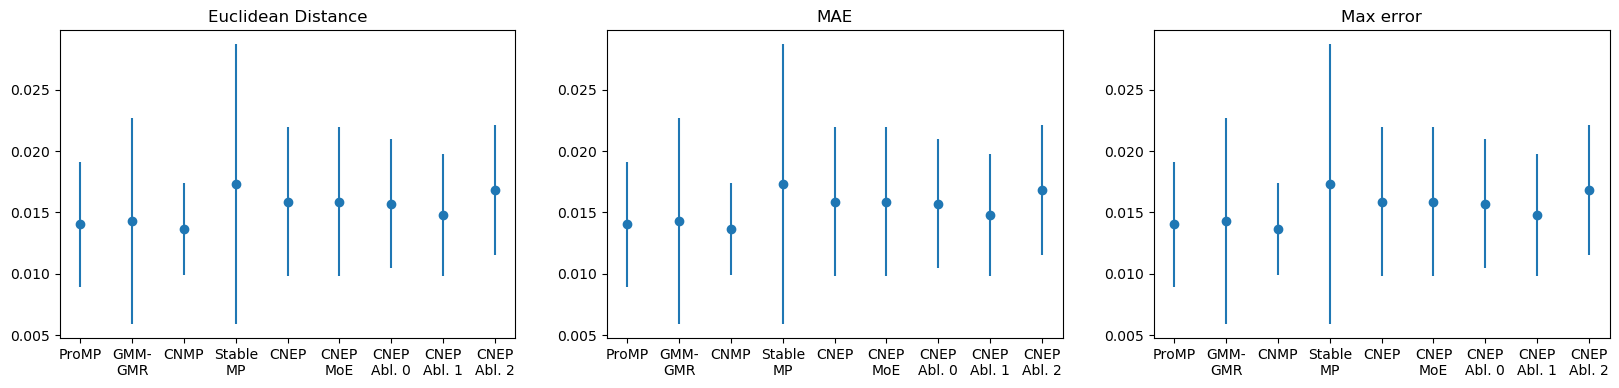

In [ ]:
# plot mean errors and standard deviations 
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
x_labels = ['ProMP', 'GMM-\nGMR', 'CNMP', 'Stable\nMP', 'CNEP', 'CNEP\nMoE', 'CNEP\nAbl. 0', 'CNEP\nAbl. 1', 'CNEP\nAbl. 2']
ax[0].errorbar(x_labels, np.mean(euc_errors, axis=0), np.std(euc_errors, axis=0), fmt='o')
ax[0].set_title('Euclidean Distance')
ax[1].errorbar(x_labels, np.mean(euc_errors, axis=0), np.std(euc_errors, axis=0), fmt='o')
ax[1].set_title('MAE')
ax[2].errorbar(x_labels, np.mean(euc_errors, axis=0), np.std(euc_errors, axis=0), fmt='o')
ax[2].set_title('Max error')
plt.show()

# fig, ax = plt.subplots(1, 3, figsize=(20, 4))
# # x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP', 'CNEP\nMoE', 'CNEP\nAbl. 0', 'CNEP\nAbl. 1', 'CNEP\nAbl. 2']
# x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP']
# ax[0].errorbar(x_labels, np.mean(rmse_errors, axis=0), np.std(rmse_errors, axis=0), fmt='o')
# ax[0].set_title('RMSE')
# ax[1].errorbar(x_labels, np.mean(mae_errors, axis=0), np.std(mae_errors, axis=0), fmt='o')
# ax[1].set_title('MAE')
# ax[2].errorbar(x_labels, np.mean(max_errors, axis=0), np.std(max_errors, axis=0), fmt='o')
# ax[2].set_title('Max error')
# plt.show()

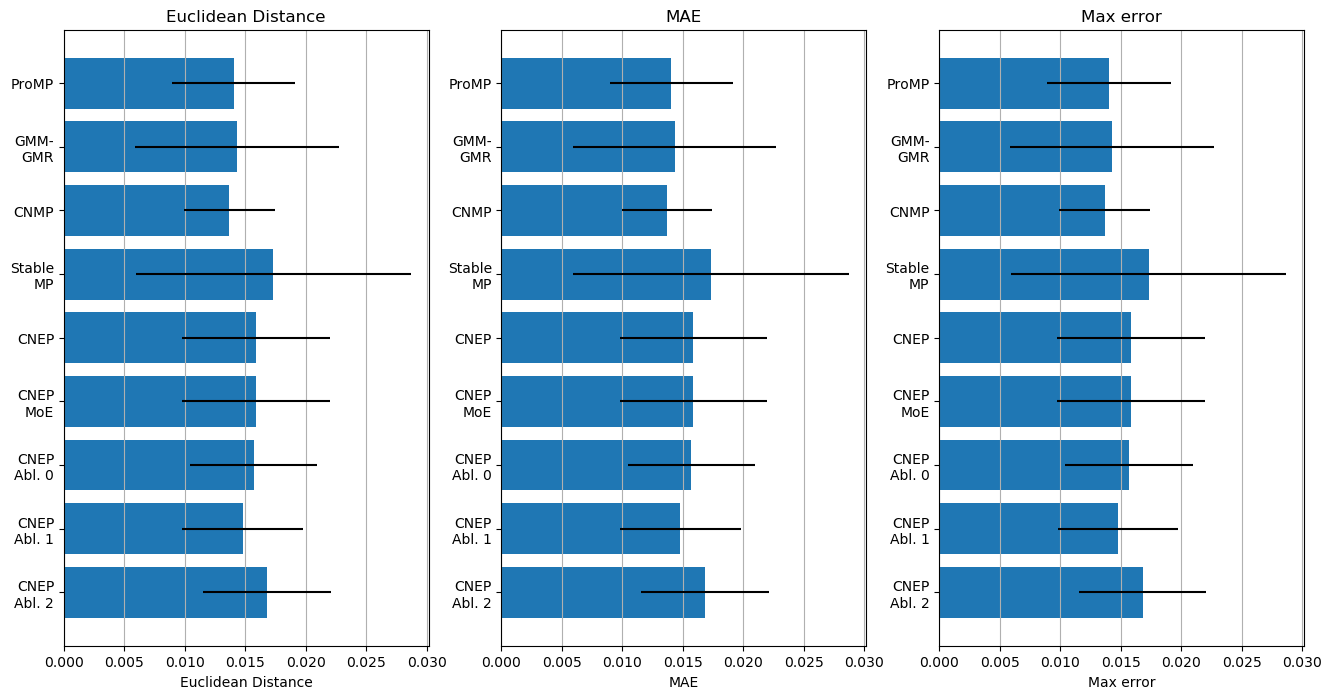

In [ ]:
# plot mean errors and standard deviations as horizontal bars
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
y_pos = np.arange(len(x_labels))
ax[0].barh(y_pos, np.mean(euc_errors, axis=0), xerr=np.std(euc_errors, axis=0), align='center')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(x_labels)
ax[0].invert_yaxis()
ax[0].set_xlabel('Euclidean Distance')
ax[0].set_title('Euclidean Distance')
ax[1].barh(y_pos, np.mean(euc_errors, axis=0), xerr=np.std(euc_errors, axis=0), align='center')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(x_labels)
ax[1].invert_yaxis()
ax[1].set_xlabel('MAE')
ax[1].set_title('MAE')
ax[2].barh(y_pos, np.mean(euc_errors, axis=0), xerr=np.std(euc_errors, axis=0), align='center')
ax[2].set_yticks(y_pos)
ax[2].set_yticklabels(x_labels)
ax[2].invert_yaxis()
ax[2].set_xlabel('Max error')
ax[2].set_title('Max error')

ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[2].grid(axis='x')
plt.show()